In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

Загрузка данных: матрицы, модельного решения и вектора свободных коэффициентов b.

In [3]:
path_to_dirs = 'C:\\Users\\Daria\\Documents\\MATLAB'
os.chdir(path_to_dirs)

# Loading matrix
matrix_filename = 'L256216.txt'
matrix_L = np.loadtxt(matrix_filename)

# Load model solution x, vector of free coefficients b
name_of_dirs = ['model_solution', 'right_coefs']
number_of_part = 5
b = []
x = []
for name in name_of_dirs:
    dir_actual = os.path.join(path_to_dirs, name)
    os.chdir(dir_actual)
    if name == name_of_dirs[0]:
        x = np.loadtxt('x_n_phi_' + str(number_of_part) +'.txt')
    else:
        b = np.loadtxt('b_n_phi_' + str(number_of_part) +'.txt')

Обработка матрицы: удаление нулевых столбцов, затем отбор наибольших по сумме строк и отбор по рангу матрицы.

In [4]:
def matrix_сut(matrix, size=20):
    deleted_rows = []
    matrix = np.array(matrix[:128, :])
    # Delete null columns
    null_columns = []
    for i in range(matrix.shape[1]):
        count = 0
        for j in range(matrix.shape[0]):
            if matrix[j][i] == 0:
                count += 1
        if count == matrix.shape[0]:
            null_columns.append(i)
    matrix = np.delete(matrix, null_columns, axis=1)
    
    # Leave most filled lines
    counters = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j] != 0:
                counters[i] += 1
    deleted_rows = []
    not_10 = False
    for i in range(len(counters)):
        if counters[i] < 11:
            deleted_rows.append(i)
    matrix = np.delete(matrix, deleted_rows, axis=0)
    
    
    indexes = []
    for i, col in enumerate(matrix.T):
        if np.fabs(col).sum() > 0:
            indexes.append(i)
    matrix = matrix.T[indexes].T

    size = min(matrix.shape[0], matrix.shape[1], size)
    
    while size > 0:
        s = 0
        for i in range(matrix.shape[0] - size + 1):
            s = 0
            for j in range(matrix.shape[1] - size + 1):
                s = 0
                if np.linalg.matrix_rank(matrix[i:i+size, j:j+size]) == size:
                    break
                s+=1
            if s == 0:
                break
        if s == 0:
            break
        size -=1
    return matrix[i:i+size, j:j+size], i, j

In [5]:
def min_from_4(a, b, c, d):
    return min(min(min(a, b), c), d)

def max_from_4(a, b, c, d):
    return max(max(max(a, b), c), d)

def mul_intervals(f_low, f_up, s_low, s_up):
    return min_from_4(f_low * s_low, f_low * s_up, f_up * s_low, f_up * s_up), \
           max_from_4(f_low * s_low, f_low * s_up, f_up * s_low, f_up * s_up)

def sum_intervals(list):
    result = [0, 0]
    for interval in list:
        result[0] += interval[0]
        result[1] += interval[1]
    return result[0], result[1]

def get_sti(vector_low, vector_up):
    return np.append(-vector_low, vector_up)

def sti_reversed(vector):
    middle = vector.shape[0] // 2
    return -vector[:middle], vector[middle:]

def get_g(vector, C, d):
    applied_sti_low, applied_sti_up = sti_reversed(vector)
    C_sti_vector = [sum_intervals([mul_intervals(C[i][j][0], C[i][j][1], applied_sti_low[j], applied_sti_up[j])
                                   for j in range(len(applied_sti_low))]) for i in range(len(C))]
    high_matrix = []
    low_matrix = []
    for interval in C_sti_vector:
        low_matrix.append(interval[0])
        high_matrix.append(interval[1])
    return get_sti(np.array(low_matrix), np.array(high_matrix)) - d

In [6]:
def dx_pos(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0.9
    else:
        return 0

def dx_neg(x):
    if x < 0:
        return -1
    elif x == 0:
        return -0.9
    else:
        return 0

def pos(x):
    return x if x > 0 else 0

def neg(x):
    return -x if x < 0 else 0

In [7]:
def dmax_first(A, i, j, x):
    n = x.shape[0] // 2
    prod_1 = pos(A[i][j][1]) * pos(x[j])
    prod_2 = neg(A[i][j][0]) * pos(x[j+n])
    if prod_1 > prod_2:
        return pos(A[i][j][1]), 0
    elif prod_1 == prod_2:
        return 0.1 * pos(A[i][j][1]), 0.1 * neg(A[i][j][0])
    else:
        return 0, neg(A[i][j][0])

def dmax_second(A, i, j, x):
    n = x.shape[0] // 2
    prod_1 = pos(A[i][j][1]) * pos(x[j+n])
    prod_2 = neg(A[i][j][0]) * pos(x[j])
    if prod_1 > prod_2:
        return 0, pos(A[i][j][1])
    elif prod_1 == prod_2:
        return 0.1 * neg(A[i][j][0]), 0.1 * pos(A[i][j][1])
    else:
        return neg(A[i][j][0]), 0

def dF(C, i, x):
    n = x.shape[0] // 2
    res = np.zeros(2 * n)
    if 0 <= i < n:
        for j in range(0, n):
            temp = dmax_first(C, i, j, x)
            res_1 = pos(C[i][j][0]) * dx_neg(x[j]) + neg(C[i][j][1]) * dx_neg(x[j+n]) - temp[0]
            res_2 = pos(C[i][j][0]) * dx_neg(x[j]) + neg(C[i][j][1]) * dx_neg(x[j+n]) - temp[1]
            res[j] -= res_1
            res[j+n] -= res_2
    else:
        i -= n
        for j in range(0, n):
            temp = dmax_second(C, i, j, x)
            res_1 = temp[0] - pos(C[i][j][0]) * dx_neg(x[j+n]) - neg(C[i][j][1]) * dx_neg(x[j])
            res_2 = temp[1] - pos(C[i][j][0]) * dx_neg(x[j+n]) - neg(C[i][j][1]) * dx_neg(x[j])
            res[j] += res_1
            res[j+n] += res_2
    return res

def get_sub_grad(C, vector):
    n = vector.shape[0]
    D = np.zeros((n, n))
    for i in range(0, n):
        D[i][:] = dF(C, i, vector)
    return D

In [8]:
def sub_grad_2(A, b_inf, b_sup, eps):
    max_iter = 1000
    sti_b = get_sti(b_inf, b_sup)
    x = np.zeros_like(sti_b)

    prev_g = get_g(x, A, sti_b)
    iter_count = 0
    while np.linalg.norm(prev_g) > eps and iter_count < max_iter:
        iter_count += 1
        sub_grad = get_sub_grad(A, x)
        func_g = get_g(x, A, sti_b)
        #print(np.linalg.det(sub_grad))
        x = np.subtract(x, np.linalg.inv(sub_grad).dot(func_g))
        #print(x)
        prev_g = func_g
    return sti_reversed(x), iter_count

Функции для рисования: визуализация корреляционной матрицы и полученного результата.

In [13]:
def heat_map(matrix, annot=False):
    div = np.max(np.fabs(matrix))
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, annot=annot, center=0)
    plt.title('Matrix coef')
    plt.xlabel('column')
    plt.ylabel('row')
    plt.show()

def plot_result(x, x_sup, x_inf, A, b, b_low, b_up, title):
    plt.plot(np.dot(A, x_inf), label='A * x_inf', color='darkblue')
    plt.plot(np.dot(A, x_sup), label='A * x_sup', color='deepskyblue')
    plt.plot(b, label='b', color='aquamarine')
    plt.plot(b_low, label='b_inf', ls='--', color='lawngreen')
    plt.plot(b_up, label='b_sup', ls='--', color='yellow')
    plt.legend()
    plt.title('Results')
    plt.grid()
    plt.savefig(title + '.png', format='png')
    plt.show()

def plot_x(x, x_inf, x_sup):
    plt.figure(figsize=(18, 8))
    plt.plot(x, label='x', color='darkred')
    plt.plot(x_inf, label='x_inf', color='orchid')
    plt.plot(x_sup, label='x_sup', color='indigo')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.title('Сравнение полученного решения с исходным')
    plt.legend()
    plt.grid()
    plt.savefig('w_s_new' + '.png', format='png')
    plt.show()

Исходная матрица


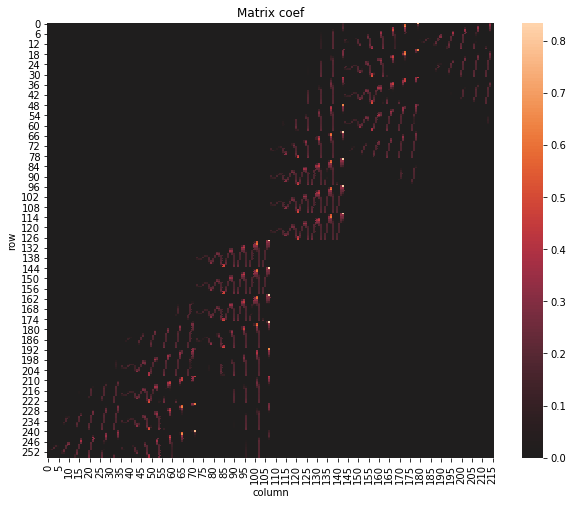

Сокращенная матрица


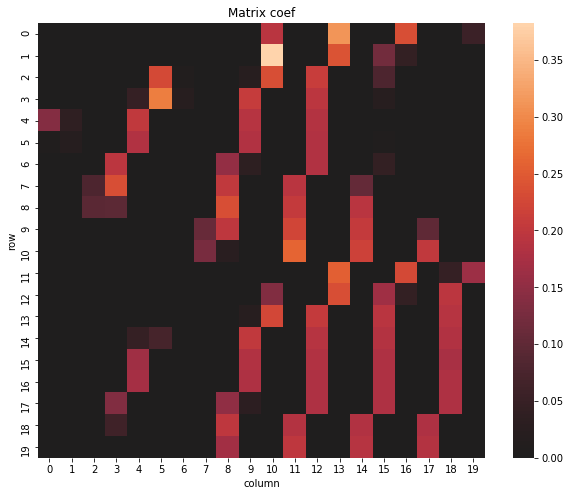

Matrix determinant:  -2.1769484601317828e-21


In [14]:
print('Исходная матрица')
heat_map(matrix_L)
matrix, i, j = matrix_сut(matrix_L)
print('Сокращенная матрица')
heat_map(matrix)
print('Matrix determinant: ', np.linalg.det(matrix))
b = b[i:i + matrix.shape[0]]
x = x[j:j + matrix.shape[0]]
rad = np.random.uniform(low=1e-3, high=1e-1, size=len(b))
b_inf = b - rad
b_sup = b + rad

Quantity of iterations:  1000


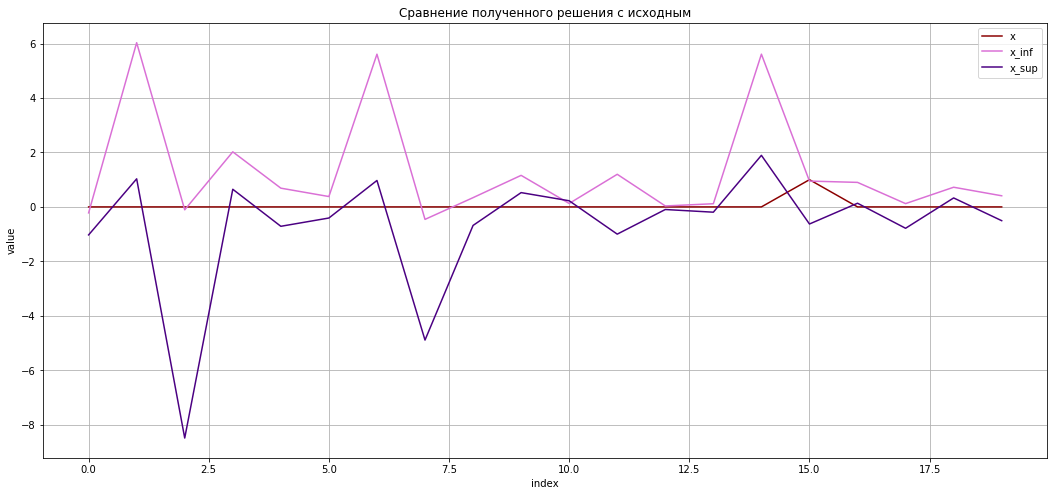

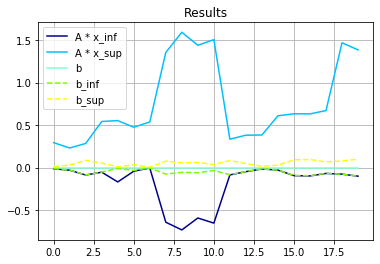

In [11]:
matrix_m = []
n = matrix.shape[0]
for i in range(len(matrix)):
    rads = np.random.uniform(low=1e-8, high=1e-3, size=n)
    array = []
    for j in range(n):
        rad_m = rads[j]
        array.append(np.append(matrix[i][j] - rad_m, matrix[i][j] + rad_m))
    matrix_m.append(array)
(x_inf, x_sup), iters = sub_grad_2(matrix_m, b_inf, b_sup, 1e-5)
print('Quantity of iterations: ', str(iters))
plot_x(x, x_sup, x_inf)
plot_result(x, x_sup, x_inf, matrix, b, b_inf, b_sup, 'n_phi_' + str(number_of_part))